# <b>Yêu cầu</b>
File Project_2_Sentiment_analysis_Collect_Preprocess_data.ipynb sẽ thực hiện những yêu cầu sau:

*   Thu thập dữ liệu từ trang web.
*   Tiền xử lý dữ liệu.
*   Gán nhãn cho dữ liệu.
*   Lưu trữ dữ liệu phục vụ phân tích và đánh giá.





# <b>Import</b>

In [40]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [41]:
!pip install google-play-scraper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
from google_play_scraper import Sort, reviews

In [43]:
import nltk
nltk.download("popular")
nltk.download('vader_lexicon')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [44]:
!pip install pyspellchecker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.2 MB/s 


In [45]:
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker

In [46]:
!pip install --upgrade gupload

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
from pydrive.auth import GoogleAuth
from google.colab import auth

# <b>Thu thập dữ liệu</b>

In [48]:
review_list, continuation_token = reviews(
    'com.facebook.katana',
    lang= 'en',
    country= 'us',
    sort= Sort.MOST_RELEVANT,
    count= 20000,
)

review_list, _ = reviews(
    'com.facebook.katana',
    continuation_token= continuation_token
)

In [49]:
review_content = []
for review in review_list:
    review_content.append(review['content'])

raw_df = pd.DataFrame()
raw_df['Content'] = np.array(review_content)
raw_df.head()

,Content
0,News feed r so annoying...not responding properly...
1,Where do I begin? I don't know why you include a data saver option in the app while it is worthless and never saves any data. Still videos load on the highest quality and to reduce it i have to click twice on a lower quality. Not kidding twice or the the video will load anyway. I wonder if you are intentinally not fixing this to help network providers in my country charge us for more. It is 2021 and internet should be free for all but in my country we are still struggling for more quota!
2,"i think u should add the options for folders for the featured photos. I mean, when I want to add photos in my featured photos from my gallery, it's hard to pick from the old up to present pics that I want to add in the featured photos. Like, im gonna wait for minutes just to scroll the other photo. What i wanted to say is u should add the options like ""gallery"" ""camera"" ""album 1"" or something like that for us to access easily the photos that we only wanted to display. Thank u!!"
3,horrible! can't scroll on pages
4,"The mobile app is all but dead after the Android 12 update. Nothing updates ; newsfeed, notifications, even messenger. I have completely uninstalled both, cleared cache and reinstalled. Woke up 7 hours later with the same entry at the top of my feed, no notifications from any of my groups and it won't refresh on command. Note 20 Ultra, unlocked, on VZW."


In [50]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Content  20000 non-null  object
dtypes: object(1)
memory usage: 156.4+ KB


# <b>Tiền xử lý dữ liệu</b>

In [51]:
pd.set_option('display.max_colwidth', None)

## <b>Tách câu</b>

In [52]:
raw_df['Content'] = raw_df['Content'].apply(lambda x: sent_tokenize(x))

In [53]:
reviews_df = raw_df.apply(lambda x: x.explode()).reset_index().iloc[:, 1:]
reviews_df.head()

,Content
0,News feed r so annoying...not responding properly...
1,Where do I begin?
2,I don't know why you include a data saver option in the app while it is worthless and never saves any data.
3,Still videos load on the highest quality and to reduce it i have to click twice on a lower quality.
4,Not kidding twice or the the video will load anyway.


## <b>In thường toàn bộ</b>

In [54]:
reviews_df['Content'] = reviews_df['Content'].str.lower().astype(str)
reviews_df.head()

,Content
0,news feed r so annoying...not responding properly...
1,where do i begin?
2,i don't know why you include a data saver option in the app while it is worthless and never saves any data.
3,still videos load on the highest quality and to reduce it i have to click twice on a lower quality.
4,not kidding twice or the the video will load anyway.


## <b>Thay thế các từ viết tắt</b>

In [55]:
abbreviations = {
    "i\'m": 'i am',
    "im": 'i am',
    "don\'t": 'do not',
    "\'t": ' not',
    "\'s": ' is',
    "\'ll": ' will',
    "\'ve": ' have',
    "ive": 'i have',
    "\'d": ' would',
    "\'re": ' are',
    "cant": 'can not',
    "dont": 'do not',
    "idk": 'i do not know',
    "cannot": 'can not',
    "fb": 'facebook',
    "pls": 'please',
    "smh": 'shaking my head',
    "btw": 'by the way',
    "cuz": 'because'
}

In [56]:
reviews_df['Content'] = reviews_df['Content'].replace(to_replace= abbreviations.keys(), value= abbreviations.values(), regex= True)
reviews_df.head()

,Content
0,news feed r so annoying...not responding properly...
1,where do i begin?
2,i do not know why you include a data saver option in the app while it is worthless and never saves any data.
3,still videos load on the highest quality and to reduce it i have to click twice on a lower quality.
4,not kidding twice or the the video will load anyway.


## <b>Loại bỏ các chữ số</b>

In [57]:
def remove_digit(text):
    result = re.sub(r'\d+', '', text)
    return ' '.join(result.split())

In [58]:
reviews_df['Content'] = reviews_df['Content'].apply(lambda text: remove_digit(text))
reviews_df.head()

,Content
0,news feed r so annoying...not responding properly...
1,where do i begin?
2,i do not know why you include a data saver option in the app while it is worthless and never saves any data.
3,still videos load on the highest quality and to reduce it i have to click twice on a lower quality.
4,not kidding twice or the the video will load anyway.


## <b>Loại bỏ các dấu câu</b>

In [59]:
reviews_df['Content'] = reviews_df['Content'].apply(lambda text: re.sub(r'\W+', ' ', text))
reviews_df.head()

,Content
0,news feed r so annoying not responding properly
1,where do i begin
2,i do not know why you include a data saver option in the app while it is worthless and never saves any data
3,still videos load on the highest quality and to reduce it i have to click twice on a lower quality
4,not kidding twice or the the video will load anyway


## <b>Loại bỏ các emoji</b>

In [60]:
def remove_emoji(string):
    emoji = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002500-\U00002BEF"  # chinese char
                u"\U00002702-\U000027B0"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u"\U00010000-\U0010ffff"
                u"\u2640-\u2642" 
                u"\u2600-\u2B55"
                u"\u200d"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\ufe0f"  # dingbats
                u"\u3030"
                "]+", flags=re.UNICODE)
    return emoji.sub(r'', string)

In [61]:
reviews_df['Content'] = reviews_df['Content'].apply(lambda text: remove_emoji(text))
reviews_df.head()

,Content
0,news feed r so annoying not responding properly
1,where do i begin
2,i do not know why you include a data saver option in the app while it is worthless and never saves any data
3,still videos load on the highest quality and to reduce it i have to click twice on a lower quality
4,not kidding twice or the the video will load anyway


## <b>Loại bỏ Stopwords</b>

In [62]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [63]:
reviews_df['Content'] = reviews_df['Content'].apply(lambda text: " ".join([word for word in str(text).split() if word not in set(stopwords.words('english'))]))
reviews_df.head()

,Content
0,news feed r annoying responding properly
1,begin
2,know include data saver option app worthless never saves data
3,still videos load highest quality reduce click twice lower quality
4,kidding twice video load anyway


## <b>Lemmatization</b>

In [64]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N": wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [65]:
reviews_df['Content'] = reviews_df['Content'].apply(lambda text: lemmatize_words(text))
reviews_df.head()

,Content
0,news feed r annoy respond properly
1,begin
2,know include data saver option app worthless never save data
3,still videos load high quality reduce click twice low quality
4,kid twice video load anyway


## <b>Sửa các lỗi chính tả</b>

In [66]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            correct_word = spell.correction(word)
            if correct_word != None:
                corrected_text.append(correct_word)
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [67]:
reviews_df['Content'] = reviews_df['Content'].apply(lambda text: correct_spellings(text))
reviews_df.head()

,Content
0,news feed i annoy respond properly
1,begin
2,know include data saver option app worthless never save data
3,still videos load high quality reduce click twice low quality
4,kid twice video load anyway


## <b>Loại bỏ từ đơn vô nghĩa</b>

In [68]:
def remove_single_word(text):
    # Loại bỏ từ đơn ở giữa câu
    result = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    result = ' '.join(result.split())
    while True:
        result = re.sub(r'\s+[a-zA-Z]\s+', ' ', result)
        result = ' '.join(result.split())
        if len(re.findall(r'\s+[a-zA-Z]\s+', result)) ==  0: break;
        

    # Loại bỏ từ đơn ở đầu câu
    result = re.sub(r'^[a-zA-Z]\s+', '', result)

    # Loại bỏ từ đơn ở cuối câu
    result = re.sub(r'\s+[a-zA-Z]$', '', result)

    return result

In [69]:
reviews_df['Content'] = reviews_df['Content'].apply(lambda text: remove_single_word(text))
reviews_df.head()

,Content
0,news feed annoy respond properly
1,begin
2,know include data saver option app worthless never save data
3,still videos load high quality reduce click twice low quality
4,kid twice video load anyway


## <b>Loại bỏ ô dữ liệu trống</b>

In [70]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72102 entries, 0 to 72101
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Content  72102 non-null  object
dtypes: object(1)
memory usage: 563.4+ KB


In [71]:
reviews_df['Content'] = reviews_df['Content'].replace('', np.nan, regex= True)
reviews_df.isna().sum()

Content    1672
dtype: int64

In [72]:
reviews_df = reviews_df.dropna().reset_index().iloc[:, 1:]
reviews_df.isna().sum()

Content    0
dtype: int64

In [73]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70430 entries, 0 to 70429
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Content  70430 non-null  object
dtypes: object(1)
memory usage: 550.4+ KB


# <b>Gán nhãn cho dữ liệu</b>

In [74]:
vader_instance = SentimentIntensityAnalyzer()

In [75]:
def assign_label(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else :
        return 'Neural'

In [76]:
sentiment_list = []
sentiment_list = reviews_df['Content'].apply(lambda text: assign_label(vader_instance.polarity_scores(text)['compound']))
reviews_df['Sentiment'] = np.array(sentiment_list)
reviews_df

,Content,Sentiment
0,news feed annoy respond properly,Negative
1,begin,Neural
2,know include data saver option app worthless never save data,Negative
3,still videos load high quality reduce click twice low quality,Negative
4,kid twice video load anyway,Neural
...,...,...
70425,facebook nothing like use go horrible,Negative
70426,sick update find gotten bad,Negative
70427,miss everything hate suck,Negative
70428,ik stick loading page,Neural


In [77]:
sentiment_count = reviews_df.groupby('Sentiment').count()['Content'].reset_index()
sentiment_count.columns = ['Sentiment', 'Count']
sentiment_count

,Sentiment,Count
0,Negative,19596
1,Neural,27426
2,Positive,23408


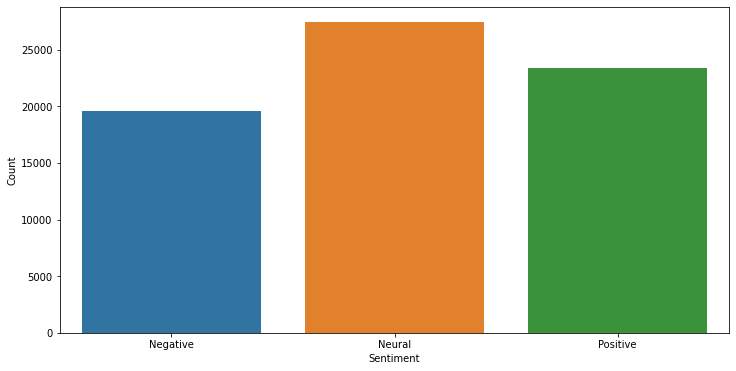

In [78]:
plt.figure(figsize=(12,6))
sns.barplot(x= 'Sentiment', y= 'Count', data= sentiment_count)
plt.show()

# <b>Lưu dữ liệu</b>

In [79]:
reviews_df.to_csv('sentiment_analysis_data.csv', index=False)

In [80]:
# Link data: https://drive.google.com/drive/u/0/folders/1MJ0FaZEr5yhOjJYONbeXSmqeypGxDJob
auth.authenticate_user()
!gupload --to '1MJ0FaZEr5yhOjJYONbeXSmqeypGxDJob' sentiment_analysis_data.csv

Uploading file: sentiment_analysis_data.csv
